In [1]:
import pathlib
import rasterio
import pprint

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
data_folder = pathlib.Path("/p/scratch/training2504/data/s2l2a-sits")
train_set_folder = data_folder / "train"
val_set_folder = data_folder / "val"


In [4]:
sample = train_set_folder/"SENTINEL2A_20200917-105852-123_L2A_T30TYQ_C_V2-2_patch_3.tif"
# sample = val_set_folder/"SENTINEL2A_20171023-105154-753_L2A_T30TYR_D_V1-4_patch_6.tif"
# sample = val_set_folder/ "SENTINEL2B_20170822-110527-982_L2A_T30TYR_C_V2-2_patch_5.tif"
assert sample.exists(), "File not found."  

In [5]:
dataset = rasterio.open(sample)

In [6]:
print(f"Number of bands: {dataset.count}")
bands_format = {i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}
pprint.pprint(bands_format)

Number of bands: 13
{1: 'int16',
 2: 'int16',
 3: 'int16',
 4: 'int16',
 5: 'int16',
 6: 'int16',
 7: 'int16',
 8: 'int16',
 9: 'int16',
 10: 'int16',
 11: 'int16',
 12: 'int16',
 13: 'int16'}


In [7]:
blue, green, red = map(lambda b: dataset.read(b), range(1, 4))
red.shape

(1024, 1024)

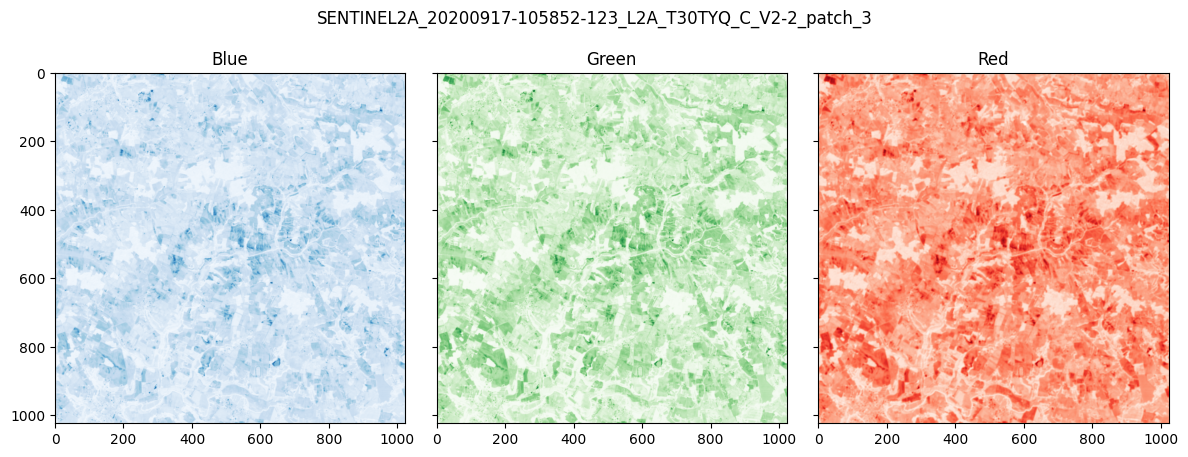

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12), sharey=True)
cmaps = ["Blues", "Greens", "Reds"]
images = map(lambda band: dataset.read(band), range(2, 5))
for idx, (cmap, image) in enumerate(zip(cmaps, images)):
    axes[idx].imshow(image, cmap=cmap)
    axes[idx].set_title(cmap[:-1])

fig.suptitle(str(sample.stem))
fig.tight_layout()
fig.subplots_adjust(top=1.55)

plt.show()


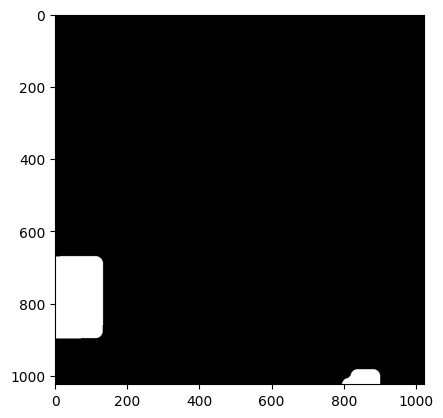

In [9]:
cloud_probs = dataset.read(11)
cloud_mask = (cloud_probs > 10).astype(np.uint8)

plt.imshow(cloud_mask, cmap="Greys_r", vmin=0, vmax=1)
plt.show()

In [11]:
def filter_cloudy(img_path: pathlib.Path, threshold: int) -> bool:
    pixel_values = rasterio.open(img_path)
    num_pixels = pixel_values.height * pixel_values.width
    
    cloud_probs = pixel_values.read(11)
    cloud_mask = cloud_probs > threshold

    return cloud_mask.sum() > (0.1 * num_pixels)

print(filter_cloudy(sample, threshold=10))

False


In [12]:
cloudy_samples = sum(filter_cloudy(path, threshold=10) for path in train_set_folder.iterdir() if str(path).endswith("tif"))

In [17]:
num_samples = len(list(filter(lambda path: str(path).endswith("tif"), train_set_folder.iterdir())))

In [22]:
cloudy_fraction = 100 * (cloudy_samples / num_samples)
print(f"Found {cloudy_samples} cloudy samples out of {num_samples} ({cloudy_fraction:.1f}%)")

Found 973 cloudy samples out of 1884 (51.6%)


In [25]:
print((num_samples - cloudy_samples) * (1024**2 / 256**2))

14576.0
